In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re
import json
import collections


from util import get_data
from util import mapping
from util import clean_data
from util import config
from util import plot_clusters
from util import process_data

import sklearn.cluster
import sklearn.neighbors
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics
import scipy
import umap

In [ ]:
def fit_tree(df, feature_importance):
    LEAF_SIZE = 20
    return sklearn.neighbors.KDTree(df * feature_importance, leaf_size=LEAF_SIZE)


# Testing out loading a route

In [ ]:
trips = pd.read_feather(config.PROCESSED_DATA_PATH + 'trips_culled_scaled.feather')
trips.set_index('rte_id', inplace=True)

In [ ]:
rte_id = 133650

URL = "http://ridewithgps.com/routes/{}.json".format(rte_id)
r = requests.get(url = URL)

In [ ]:
d = r.json()
df = pd.DataFrame(d['track_points'])[['y', 'x', 'e']]
df['t'] = 0
df = clean_data.clean_single_trip(df)
df.to_feather(config.CLEAN_TRIPS_PATH + 'route_{}.feather'.format(rte_id))

In [ ]:
td = process_data.get_features_from_rte_files(['route_133650'])
td.set_index('rte_id', inplace=True)
td_scaled = process_data.apply_scaling(td)
td_scaled.head()

In [ ]:
feature_importance_dict = {'dist': 1.,
                      'avg_slope_climbing': 0.2,
                      'avg_slope_descending': 0.01,
                      'max_slope': 0.2,
                      'dist_climbing': 0.3,
                      'dist_downhill': 0.01,
                      'dist_6percent': 0.2,
                      'dist_9percent': 0.2,
                      'dist_12percent': 0.1,
                      'avg_speed': 0.,
                        }
feature_sc = [v for v in feature_importance_dict.values()]
tree = fit_tree(trips, feature_sc)

dists, df_inds = tree.query(td_scaled * feature_sc, k=5)
dists, df_inds = dists.flatten(), df_inds.flatten()
neighbour_rte_ids = trips.index[df_inds].tolist()

trips_unscaled = process_data.remove_scaling(trips.loc[neighbour_rte_ids])
trips_unscaled.append(td)

# Using the book routes

In [3]:
rte_ids = {
    'easy': [34334830, 34334875, 34334946, 34334973, 34334993, 
             34335057, 34335164, 34335190, 34335257],
    'moderate': [34334760, 34334840, 34334850, 34334931, 34335019,
                  34335063, 34335072, 34335087, 34335143, 34335210,
                  34335223, 34335265, 34335284, 34335362, 34335395],
    'strenuous': [34334791, 34334812, 34334864, 34334890, 
               34334909, 34334917, 34334959, 34335041,
               34335104, 34335111, 34335122, 34335154,
               34335236, 34335379],
}


In [4]:

# for rte_id in [i for v in rte_ids.values() for i in v]:
#     URL = "http://ridewithgps.com/routes/{}.json".format(rte_id)
#     r = requests.get(url = URL)
    
#     d = r.json()
#     df = pd.DataFrame(d['track_points'])[['y', 'x', 'e']]
#     df['t'] = 0
#     df = clean_data.clean_single_trip(df)
#     df.to_feather(config.CLEAN_TRIPS_PATH + 'route_{}.feather'.format(rte_id))

In [8]:
fns = ['route_{}'.format(rte_id) for v in rte_ids.values() for rte_id in v]
e_ids = ['route_{}'.format(v) for v in rte_ids['easy']]
m_ids = ['route_{}'.format(v) for v in rte_ids['moderate']]
s_ids = ['route_{}'.format(v) for v in rte_ids['strenuous']]
td = process_data.get_features_from_rte_files(fns)
td.set_index('rte_id', inplace=True)
td.fillna(0, inplace=True)
# td_scaled = process_data.apply_scaling(td)
# td_scaled.head()
td.tail()

0


,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent,avg_speed
rte_id,,,,,,,,,,
route_34335111,27.529178,3.885185,-2.667329,13.631522,0.139095,0.190398,0.082324,0.069642,0.032014,0.0
route_34335122,13.728860,5.867839,-6.628352,14.264638,0.242452,0.302570,0.149208,0.098029,0.029187,0.0
route_34335154,31.495622,5.216349,-3.170630,14.264638,0.179853,0.200344,0.097305,0.041229,0.012723,0.0
route_34335236,23.363356,3.996244,-1.523094,8.759389,0.237189,0.169624,0.053154,0.000000,0.000000,0.0
route_34335379,20.808106,3.156952,-3.192167,7.845883,0.202618,0.195315,0.024392,0.000000,0.000000,0.0


In [ ]:
feature_importance_dict = {'dist': 1.,
                      'avg_slope_climbing': 0.2,
                      'avg_slope_descending': 0.01,
                      'max_slope': 0.2,
                      'dist_climbing': 0.3,
                      'dist_downhill': 0.01,
                      'dist_6percent': 0.2,
                      'dist_9percent': 0.2,
                      'dist_12percent': 0.1,
                      'avg_speed': 0.,
                        }
feature_sc = [v for v in feature_importance_dict.values()]

t = td_scaled #* feature_sc
t['rating'] = 0
t.loc[e_ids, 'rating'] = 0
t.loc[m_ids, 'rating'] = 1
t.loc[s_ids, 'rating'] = 2
t['rating'] = t.rating.apply(lambda x: str(x))

t.loc[e_ids, 'rating'] = 'easy'
t.loc[m_ids, 'rating'] = 'easy'
t.loc[s_ids, 'rating'] = 'hard'
t.head()

In [ ]:
colours = sns.color_palette('husl', 3)

for col in td.columns:
    if col == 'rating': continue
    plt.figure()
    sns.histplot(td, x=col, hue='rating')
# g.map_offdiag(sns.scatterplot, edgecolor=None, s=10)
# g.map_diag(sns.histplot)

In [ ]:
col1 = 'dist'
col2 = 'avg_slope_climbing'
plt.plot(t.loc[e_ids][col1], t.loc[e_ids][col2], 'g.')
plt.plot(t.loc[m_ids][col1], t.loc[m_ids][col2], 'b.')
plt.plot(t.loc[s_ids][col1], t.loc[s_ids][col2], 'r.')

In [36]:
tdf = td.copy()
tdf['rating'] = 0
tdf.loc[s_ids, 'rating'] = 1

tdf.dist = np.log(tdf.dist)
tdf = tdf[tdf.max_slope < 25]
tdf.dist_6percent = np.log(tdf.dist_6percent + 1e-2)
tdf.dist_12percent = np.log(tdf.dist_12percent + 1e-2)
tdf.dist_9percent = np.log(tdf.dist_9percent + 1e-2)

ratings = tdf.rating
tdf.drop('rating', axis=1, inplace=True)

tdf = process_data.scale_dataset(tdf)

In [71]:
td.describe()

,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent,avg_speed
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.0
mean,17.742933,3.755112,-2.142580,9.183412,0.159639,0.133419,0.068950,0.037324,0.015799,0.0
std,8.202298,2.061776,1.601431,7.457204,0.135065,0.102490,0.088992,0.068361,0.038419,0.0
min,4.107682,0.000000,-6.990116,0.445997,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,12.666105,2.083470,-3.090396,3.690490,0.027660,0.043836,0.000000,0.000000,0.000000,0.0
50%,16.013025,3.508595,-1.758273,7.651842,0.165414,0.118581,0.030414,0.000000,0.000000,0.0
75%,22.126540,5.153414,-1.071793,13.305532,0.236608,0.194085,0.123359,0.053484,0.012823,0.0
max,42.877222,7.806637,0.084700,41.096747,0.609237,0.355036,0.337090,0.311218,0.208228,0.0


In [67]:
print(len(e_ids), len(m_ids), len(s_ids))

# Split into train and test
target_name = 'rating'
# target = tdf[target_name]
# data = tdf.drop([target_name], axis=1).copy()
data = tdf.copy()
target = ratings

X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(data, target, random_state=42)
)
print(y_train.shape, y_test.shape)

9 15 14
(27,) (10,)


In [68]:
# model = sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear')
model = sklearn.linear_model.LogisticRegression()
cols = X_train.columns.tolist()
cols.remove('avg_speed')
cols.remove('dist_climbing')
cols.remove('dist_downhill')
cols.remove('avg_slope_climbing')
cols.remove('dist_9percent')

model.fit(X_train[cols], y_train)
print('AUROC: {:.4f};\nPrecision: {:.4f};\nRecall: {:.4f}\nAccuracy: {:.4f}\n\n'.format(
    sklearn.metrics.roc_auc_score(y_train, model.predict(X_train[cols])),
    sklearn.metrics.precision_score(y_train, model.predict(X_train[cols])),
    sklearn.metrics.recall_score(y_train, model.predict(X_train[cols])),
    sklearn.metrics.accuracy_score(y_train, model.predict(X_train[cols])),
))
print('AUROC: {:.4f};\nPrecision: {:.4f};\nRecall: {:.4f}\nAccuracy: {:.4f}\n\n'.format(
    sklearn.metrics.roc_auc_score(y_test, model.predict(X_test[cols])),
    sklearn.metrics.precision_score(y_test, model.predict(X_test[cols])),
    sklearn.metrics.recall_score(y_test, model.predict(X_test[cols])),
    sklearn.metrics.accuracy_score(y_test, model.predict(X_test[cols])),
))
# a = pd.DataFrame(model.coef_.T, columns=model.classes_, index=cols)
# a[['easy', 'moderate', 'hard']]
a = pd.DataFrame({'feature_names': cols, 'scaling': model.coef_.flatten()})
print(a)


feature_sc = model.coef_.flatten().tolist() + [0.]

AUROC: 0.8889;
Precision: 1.0000;
Recall: 0.7778
Accuracy: 0.9259


AUROC: 0.9000;
Precision: 1.0000;
Recall: 0.8000
Accuracy: 0.9000


          feature_names   scaling
0                  dist  1.424185
1  avg_slope_descending -0.851054
2             max_slope  0.619111
3         dist_6percent  0.469637
4        dist_12percent  0.195181


In [48]:
for i, row in a.iterrows():
    print(row.scaling)
    break

1.4547590032536812


In [69]:
a.to_feather(config.MODEL_PATH + 'feature_importance.feather')

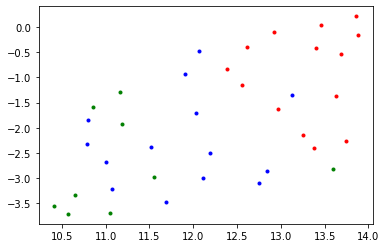

In [14]:
reducer = umap.UMAP().fit_transform(td)
umapped = pd.DataFrame({'x': reducer[:, 0], 'y': reducer[:, 1]},
                        index = td.index)

mm_ids = m_ids.copy()
mm_ids.remove('route_34334931')
plt.plot(umapped.loc[e_ids].x, umapped.loc[e_ids].y, 'g.')
plt.plot(umapped.loc[mm_ids].x, umapped.loc[mm_ids].y, 'b.')
plt.plot(umapped.loc[s_ids].x, umapped.loc[s_ids].y, 'r.')

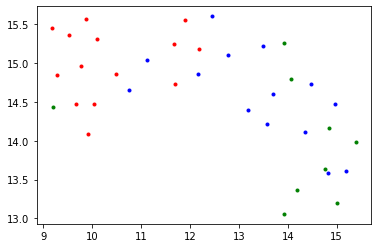

In [12]:
reducer = umap.UMAP().fit_transform(tdf)
umapped = pd.DataFrame({'x': reducer[:, 0], 'y': reducer[:, 1]},
                        index = tdf.index)

mm_ids = m_ids.copy()
mm_ids.remove('route_34334931')
plt.plot(umapped.loc[e_ids].x, umapped.loc[e_ids].y, 'g.')
plt.plot(umapped.loc[mm_ids].x, umapped.loc[mm_ids].y, 'b.')
plt.plot(umapped.loc[s_ids].x, umapped.loc[s_ids].y, 'r.')


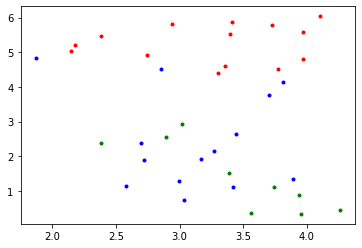

In [31]:
reducer = umap.UMAP().fit_transform(tdf * feature_sc)
umapped = pd.DataFrame({'x': reducer[:, 0], 'y': reducer[:, 1]},
                        index = tdf.index)

mm_ids = m_ids.copy()
mm_ids.remove('route_34334931')
plt.plot(umapped.loc[e_ids].x, umapped.loc[e_ids].y, 'g.')
plt.plot(umapped.loc[mm_ids].x, umapped.loc[mm_ids].y, 'b.')
plt.plot(umapped.loc[s_ids].x, umapped.loc[s_ids].y, 'r.')